In [1]:
import urllib
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

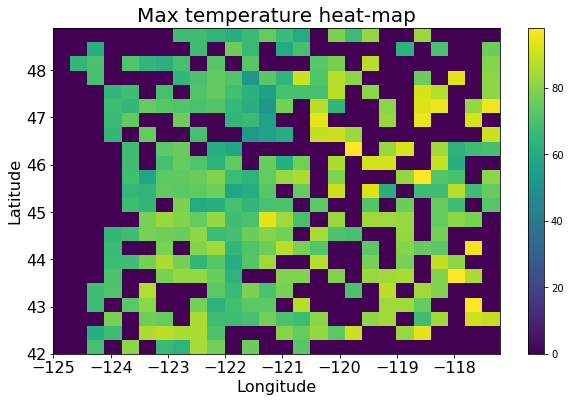

In [10]:
# pull data
resp = urllib.request.urlopen('http://data.rcc-acis.org/MultiStnData?state=OR,WA&date=2008-07-04&elems=maxt,mint').read()
stationJson = json.loads(resp)['data']

# build dataframe for data
lat = []
long = []
maxt = []
for j in range(len(stationJson)):
    if list(stationJson[j]['meta'].keys())[1]=='ll':
        long.append(stationJson[j]['meta']['ll'][0])
        lat.append(stationJson[j]['meta']['ll'][1])
        maxt.append(stationJson[j]['data'][0])
df = pd.DataFrame(list(zip(*[lat, long, maxt])), columns=['lat', 'long', 'maxt'])

# Clean up data: get rid of non-number temperatures, round lat's and long's
df['maxt'] = pd.to_numeric(df['maxt'], errors='coerce')
df = df[df['maxt'] > 0]
df['lat'] = df['lat'].round(1)
df['long'] = df['long'].round(1)

# Create arrays for 'heat map'
lat_arr = np.arange(min(np.floor(lat)),max(np.floor(lat)),0.3)
long_arr = np.arange(min(np.floor(long)),max(np.floor(long)),0.3)
t_arr = np.zeros((len(long_arr), len(lat_arr)))
t_arr_n = np.zeros((len(long_arr), len(lat_arr)))
t_arr_avg = np.zeros((len(long_arr), len(lat_arr)))

for i in range(len(df)):
    x_index = np.where(np.isclose(df['long'].iloc[i], long_arr, atol=0.15))[0]
    y_index = np.where(np.isclose(df['lat'].iloc[i], lat_arr, atol=0.15))[0]
    if (len(x_index) > 0) & (len(y_index) > 0):
        t_arr[x_index[0], y_index[0]] += df['maxt'].iloc[i]
        t_arr_n [x_index[0], y_index[0]] += 1.

for i in range(len(long_arr)):
    for j in range(len(lat_arr)):
        if t_arr[i,j] > 0:
            t_arr_avg[i,j] = t_arr[i,j] / t_arr_n[i,j]

plt.figure(figsize=(10,6))
plt.pcolor(long_arr, lat_arr, np.transpose(t_arr_avg))
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('Max temperature heat-map', size=20)
plt.xlabel('Longitude', size=16)
plt.ylabel('Latitude', size=16)
plt.colorbar()
plt.show()

In [11]:
import numpy, scipy.io

scipy.io.savemat('t_arr_avg.mat', mdict={'arr': np.transpose(t_arr_avg)})

In [ ]:
from netCDF4 import Dataset
from numpy import arange, dtype

# the output array to write will be nx x ny
nx = 600; ny = 1200
# open a new netCDF file for writing.
ncfile = Dataset('maxt.nc','w') 
# create the output data.
data_out = arange(nx*ny) # 1d array
data_out.shape = (nx,ny) # reshape to 2d array
# create the x and y dimensions.
ncfile.createDimension('x',nx)
ncfile.createDimension('y',ny)
# create the variable (4 byte integer in this case)
# first argument is name of variable, second is datatype, third is
# a tuple with the names of dimensions.
data = ncfile.createVariable('data',dtype('int32').char,('x','y'))
# write data to variable.
data[:] = data_out
# close the file.
ncfile.close()
# print '*** SUCCESS writing example file simple_xy.nc!'
